In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import statistics
import math
sns.set_style('whitegrid')
import scipy
import sklearn
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


# Models
from sklearn import neighbors
from sklearn import ensemble

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [79]:
# Upload the data into Jupyter Notebook
df = pd.read_csv('/Users/cappsjr/Downloads/kc_house_data.csv')

# Take a quick peak at the data
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


In [80]:
# Rename the variables into something recognizable
df.columns = ['ID', 'Date', 'Price', 'Bedrooms', 'Bathrooms', 'House_Size_Sqft', 'Lot_Size_Sqft', 
             'Number_of_Floors', 'Waterfront', 'View', 'Condition', 'Grade', 'House_Size_Without_Basement_Sqft',
             'Basement_Size_Sqft', 'Year_Built', 'Year_Renovated', 'Zipcode', 'Latitude', 'Longitude',
             'sqft_living15', 'sqft_lot15']
df.head(2)

,ID,Date,Price,Bedrooms,Bathrooms,House_Size_Sqft,Lot_Size_Sqft,Number_of_Floors,Waterfront,View,...,Grade,House_Size_Without_Basement_Sqft,Basement_Size_Sqft,Year_Built,Year_Renovated,Zipcode,Latitude,Longitude,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


In [81]:
# Drop sqft_living15 and sqft_lot15 because I don't know what they are, and they are highly correlated with
# sqft_living and sqft_lot

df = df.drop(['sqft_living15', 'sqft_lot15'], axis=1)

In [82]:
# Drop house size without basement because it is highly correlated to house size

df = df.drop(['House_Size_Without_Basement_Sqft'], axis=1)

In [83]:
# Lets make new categorical variables showing whether each house 1) has a basement; 2) was renovated.
df['Has_Basement'] = np.where(df['Basement_Size_Sqft'] > 0, 1, 0)
df['Was_Renovated'] = np.where(df['Year_Renovated'] > 0, 1, 0)

df.head(2)

,ID,Date,Price,Bedrooms,Bathrooms,House_Size_Sqft,Lot_Size_Sqft,Number_of_Floors,Waterfront,View,Condition,Grade,Basement_Size_Sqft,Year_Built,Year_Renovated,Zipcode,Latitude,Longitude,Has_Basement,Was_Renovated
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,0,0
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,1,1


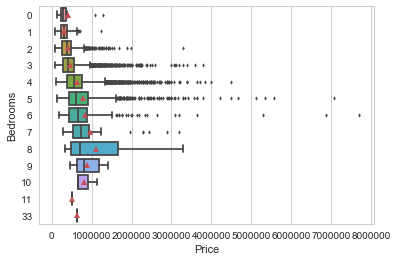

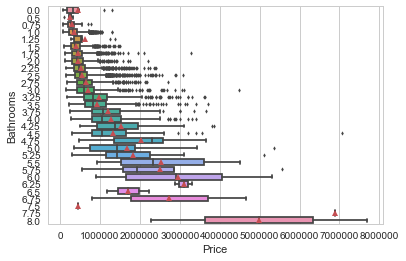

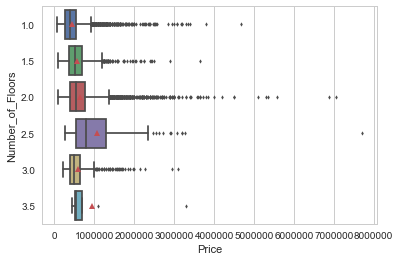

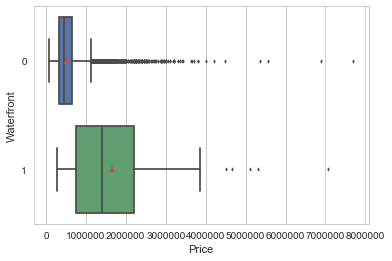

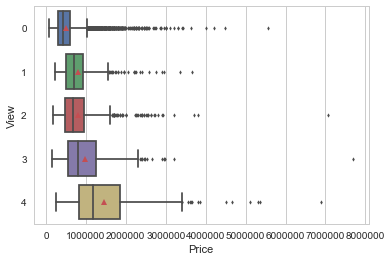

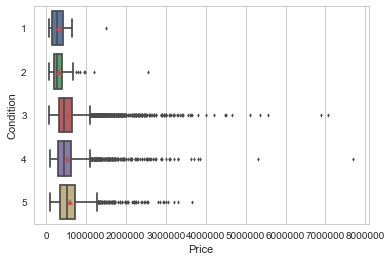

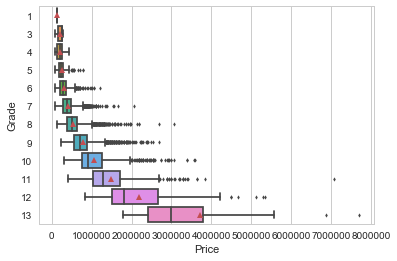

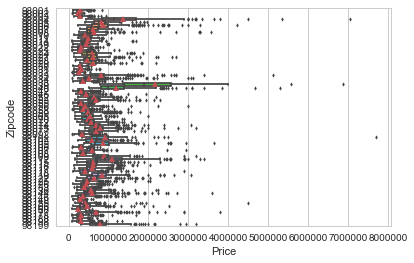

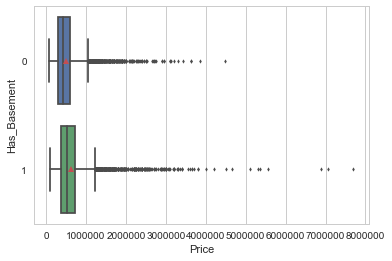

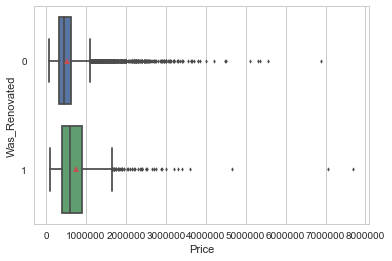

In [84]:
# Now lets take a look at relationship between the categorical variables and my target variable.
cat_var = ['Bedrooms', 'Bathrooms', 'Number_of_Floors', 'Waterfront', 'View', 'Condition', 'Grade', 'Zipcode', 
          'Has_Basement', 'Was_Renovated']

for items in cat_var:
    sns.boxplot(y=items, x='Price', orient='h', data=df, showmeans=True, fliersize=3)
    plt.show()

In [85]:
# Lets look at the number of unique values in each of the categorical variables before we convert them to dummies.
for items in cat_var:
    print(len(df[items].unique()))

13
30
6
2
5
5
12
70
2
2


In [86]:
df.describe()

,ID,Price,Bedrooms,Bathrooms,House_Size_Sqft,Lot_Size_Sqft,Number_of_Floors,Waterfront,View,Condition,Grade,Basement_Size_Sqft,Year_Built,Year_Renovated,Zipcode,Latitude,Longitude,Has_Basement,Was_Renovated
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,0.392680,0.042289
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,0.488358,0.201253
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,0.000000,0.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,0.000000,0.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,0.000000,0.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,1.000000,0.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,1.000000,1.000000


In [87]:
bins = [0, 321950, 450000, 645000, 7700000]
group_names = ['Low', 'Medium', 'High', 'Very High']

categories = pd.cut(df['Price'], bins, labels=group_names)
df['Price_Level'] = pd.cut(df['Price'], bins, labels=group_names)
df['Prices_Binned'] = pd.cut(df['Price'], bins)

In [88]:
pd.value_counts(df['Price_Level'])

Medium       5460
Low          5404
High         5376
Very High    5373
Name: Price_Level, dtype: int64

In [89]:
df.head(5)

,ID,Date,Price,Bedrooms,Bathrooms,House_Size_Sqft,Lot_Size_Sqft,Number_of_Floors,Waterfront,View,...,Basement_Size_Sqft,Year_Built,Year_Renovated,Zipcode,Latitude,Longitude,Has_Basement,Was_Renovated,Price_Level,Prices_Binned
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,1955,0,98178,47.5112,-122.257,0,0,Low,"(0, 321950]"
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,400,1951,1991,98125,47.7210,-122.319,1,1,High,"(450000, 645000]"
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,0,1933,0,98028,47.7379,-122.233,0,0,Low,"(0, 321950]"
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,910,1965,0,98136,47.5208,-122.393,1,0,High,"(450000, 645000]"
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,1987,0,98074,47.6168,-122.045,0,0,High,"(450000, 645000]"


In [16]:
# Feature selection function with random forest as the estimator
def ranfor_fselector(X, y, n_est, max_dep):
    params = {'n_estimators': n_est, 'max_depth': max_dep}
    rfc = ensemble.RandomForestClassifier(**params)
    rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(3),
              scoring='accuracy')
    fit = rfecv.fit(X, y)
    pred = rfecv.predict(X)
    score = rfecv.score(X, y)
    print('Number of Features Used: ', rfecv.n_features_)
    print('\nFeature Ranking: ', rfecv.ranking_)

In [90]:
# Run feature selection function
var_fselect = df.drop(['Price', 'ID', 'Date', 'Prices_Binned', 'Price_Level', ], axis=1)

ranfor_fselector(var_fselect, df['Price_Level'], 500, 5)

Number of Features Used:  9

Feature Ranking:  [1 1 1 1 3 8 1 6 1 4 1 7 1 1 2 5 9]


In [91]:
# Get a list of the features to determine which features were selected by the feature selection function
var_fselect.columns

Index(['Bedrooms', 'Bathrooms', 'House_Size_Sqft', 'Lot_Size_Sqft',
       'Number_of_Floors', 'Waterfront', 'View', 'Condition', 'Grade',
       'Basement_Size_Sqft', 'Year_Built', 'Year_Renovated', 'Zipcode',
       'Latitude', 'Longitude', 'Has_Basement', 'Was_Renovated'],
      dtype='object')

In [92]:
# Create a variable that includes only those features chosen by the feature selection function
rf_feats = df[['Bedrooms', 'Bathrooms', 'House_Size_Sqft', 'Lot_Size_Sqft', 'View',
              'Grade', 'Year_Built', 'Zipcode', 'Latitude']]

In [47]:
# Lets make a function to run a K nearest neighbor weighted classifier model
    
# Weighted
def knnC_w(X, y, n, cvk):
    X = StandardScaler().fit_transform(X)
    offset = int(X.shape[0] * 0.9)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    knn = neighbors.KNeighborsClassifier(n_neighbors=n, weights='distance')
    fit = knn.fit(X_train, y_train)
    pred= knn.predict(X_test)
    score = knn.score(X_test, y_test)
    cm = confusion_matrix(y_test, pred)
    fig, ax = plt.subplots()
    im = ax.matshow(cm)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.title('Confusion matrix')
    fig.colorbar(im)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    class_rep = classification_report(y_test, pred)
    print('\nClassification Report: \n', class_rep)
    print("Percent of CORRECTLY labeled points out of a total {} points : {}".format(
    len(y_test),
    (1 - (y_test != pred).sum() / len(y_test)) * 100
))
    knnC_crossval = cross_val_score(knn, X, y, scoring='accuracy', cv=cvk)
    print('\nCross-validated Scores: \n', knnC_crossval)
    print('\nMean Accuracy of Cross-Validated Scores: %0.2f (+/- %0.2f)' % (knnC_crossval.mean(), knnC_crossval.std() * 2))

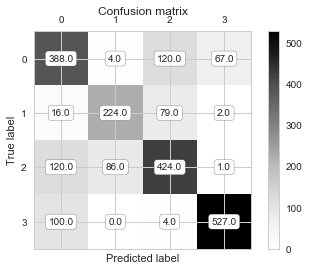


Classification Report: 
              precision    recall  f1-score   support

       High       0.62      0.67      0.65       579
        Low       0.71      0.70      0.71       321
     Medium       0.68      0.67      0.67       631
  Very High       0.88      0.84      0.86       631

avg / total       0.73      0.72      0.72      2162

Percent of CORRECTLY labeled points out of a total 2162 points : 72.29417206290472

Cross-validated Scores: 
 [ 0.72317299  0.70830442  0.72334027  0.72235076  0.73015506]

Mean Accuracy of Cross-Validated Scores: 0.72 (+/- 0.01)


In [95]:
# Define the arguments and run the weighted knn model

knnC_w(rf_feats, df['Price_Level'], 10, 5)

In [32]:
# Lets create a function for our random forest classifier
def ranfor_class(X, y, n_est, max_dep, cvk):
    offset = int(X.shape[0] * 0.9)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    rfc = ensemble.RandomForestClassifier(n_estimators=n_est, max_depth=max_dep)
    rfc_fit = rfc.fit(X_train, y_train)
    rfc_pred = rfc.predict(X_test)
    rfc_score = rfc.score(X_test, y_test)
    cm = confusion_matrix(y_test, rfc_pred)
    fig, ax = plt.subplots()
    im = ax.matshow(cm)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.title('Confusion matrix')
    fig.colorbar(im)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    class_rep = classification_report(y_test, rfc_pred)
    print('\nClassification Report: \n', class_rep)
    print("Percent of CORRECTLY labeled points out of a total {} points : {}".format(
    len(y_test),
    (1 - (y_test != rfc_pred).sum() / len(y_test)) * 100
))
    rfc_crossval = cross_val_score(rfc, X, y, scoring='accuracy', cv=cvk)
    print('\nCross Validated Scores: \n', rfc_crossval)
    print('\n Mean Accuracy of Cross-Validated Scores: %0.2f (+/- %0.2f)' % (rfc_crossval.mean(), rfc_crossval.std() * 2))
    # Make importances relative to max importance
    feature_importance = rfc.feature_importances_
    feature_importance = 100 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) +  0.5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative importance')
    plt.ylabel('Variable importance')
    plt.show()

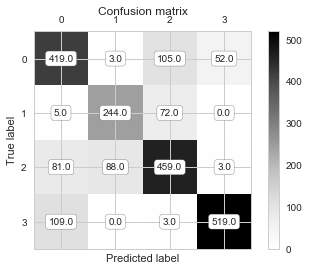


Classification Report: 
              precision    recall  f1-score   support

       High       0.68      0.72      0.70       579
        Low       0.73      0.76      0.74       321
     Medium       0.72      0.73      0.72       631
  Very High       0.90      0.82      0.86       631

avg / total       0.76      0.76      0.76      2162

Percent of CORRECTLY labeled points out of a total 2162 points : 75.90194264569843

Cross Validated Scores: 
 [ 0.75855689  0.75086745  0.75965765  0.74780194  0.77019209]

 Mean Accuracy of Cross-Validated Scores: 0.76 (+/- 0.02)


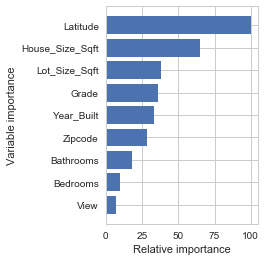

In [96]:
# Run the random forest model with the selected features

ranfor_class(rf_feats, df['Price_Level'], 500, None, 5)

In [60]:
# Now we will make a Gradient Boosting Classifier function

def gb_class(X, y, los, n, md, cvk):
    offset = int(X.shape[0] * 0.9)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    gbc = ensemble.GradientBoostingClassifier(loss=los, n_estimators=n, max_depth=md)
    gbc_fit = gbc.fit(X_train, y_train)
    gbc_pred = gbc.predict(X_test)
    gbc_score = gbc.score(X_test, y_test)
    cm = confusion_matrix(y_test, gbc_pred)
    fig, ax = plt.subplots()
    im = ax.matshow(cm)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.title('Confusion matrix')
    fig.colorbar(im)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    class_rep = classification_report(y_test, gbc_pred)
    print('\nClassification Report: \n', class_rep)
    print("Percent of CORRECTLY labeled points out of a total {} points : {}".format(
    len(y_test),
    (1 - (y_test != gbc_pred).sum() / len(y_test)) * 100
))
    gbc_crossval = cross_val_score(gbc, X, y, cv=cvk)
    print('\nCross Validated Scores: \n', gbc_crossval)
    print('\n Mean Accuracy of Cross-Validated Scores: %0.2f (+/- %0.2f)' % (gbc_crossval.mean(), gbc_crossval.std() * 2))
    # Make importances relative to max importance
    feature_importance = gbc.feature_importances_
    feature_importance = 100 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) +  0.5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative importance')
    plt.ylabel('Variable importance')
    plt.show()

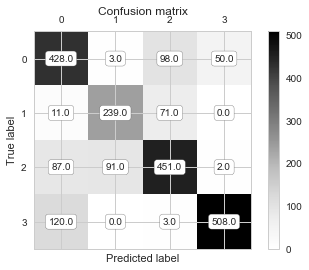


Classification Report: 
              precision    recall  f1-score   support

       High       0.66      0.74      0.70       579
        Low       0.72      0.74      0.73       321
     Medium       0.72      0.71      0.72       631
  Very High       0.91      0.81      0.85       631

avg / total       0.76      0.75      0.75      2162

Percent of CORRECTLY labeled points out of a total 2162 points : 75.2081406105458

Cross Validated Scores: 
 [ 0.75208141  0.72935461  0.74739764  0.73692735  0.751215  ]

 Mean Accuracy of Cross-Validated Scores: 0.74 (+/- 0.02)


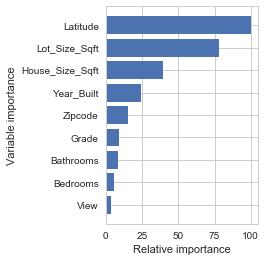

In [97]:
# Run the gradient boosting classifier with the selected features

gb_class(rf_feats, df['Price_Level'], 'deviance', 500, None, 5)